## Beam deflection with double integration

In [ ]:
%matplotlib widget
# Documentation needed for ipyml - notifications on push from github

from bmcs_utils.api import InteractiveModel, InteractiveWindow, Item, View
from bmcs_beam.models.moment_curvature.moment_curvature import MomentCurvature

import numpy as np
import sympy as sp
import traits.api as tr
import matplotlib.pylab as plt

from matplotlib.path import Path
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
import ipywidgets as widgets

from scipy.integrate import cumtrapz
sp.init_printing()

from scipy.signal import find_peaks
from sympy.physics.continuum_mechanics.beam import Beam
# https://docs.sympy.org/latest/modules/physics/continuum_mechanics/beam_problems.html

### beam configuration examples


In [ ]:
# 3 point bending example

x, E, I, F = sp.symbols('x E I F')
l = sp.symbols('l', positive=True) # the l sign
b3p = Beam(l, E, I)
R1,R2 = sp.symbols('R1 R2')
b3p.apply_load(R1, 0, -1)
b3p.apply_load(R2, l, -1)
b3p.apply_load(-F, l/2, -1)
b3p.bc_deflection = [(0, 0),(l, 0)]
b3p.solve_for_reaction_loads(R1, R2)

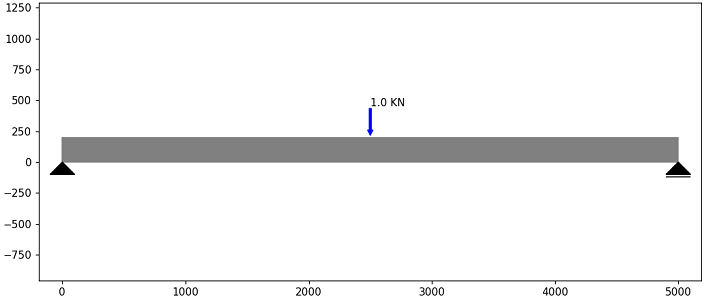

In [ ]:
# 4 point bending example

x, E, I, F = sp.symbols('x E I F')
l = sp.symbols('l', positive=True)
b4p = Beam(l, E, I)
R1,R2 = sp.symbols('R1  R2')
b4p.apply_load(R1, 0, -1)
b4p.apply_load(R2, l, -1)
b4p.apply_load(-F, l/3, -1)
b4p.apply_load(-F, 2*l/3, -1)
b4p.bc_deflection = [(0, 0),(l, 0)]
b4p.solve_for_reaction_loads(R1, R2)

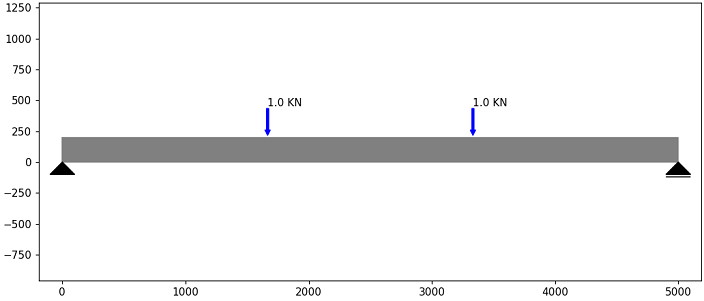

In [ ]:
# single moment example

x, E, I, F = sp.symbols('x E I F')
l = sp.symbols('l', positive=True) # the l sign
bmo = Beam(l, E, I)
R1,R2 = sp.symbols('R1 R2')
bmo.apply_load(R1, 0, -1)
bmo.apply_load(R2, l, -1)
bmo.apply_load(F, l/2, -2)
bmo.bc_deflection = [(0, 0),(l, 0)]
bmo.solve_for_reaction_loads(R1, R2)

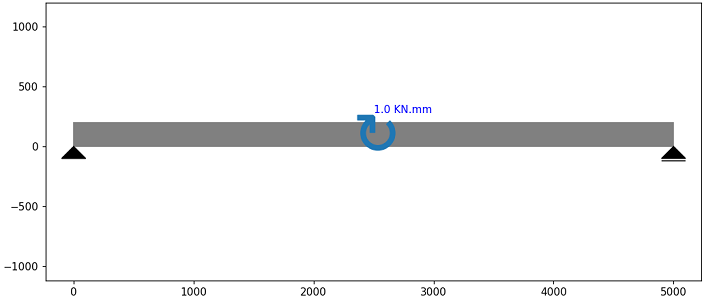

In [ ]:
# distrubuted load simple beam example

E,I,M,V = sp.symbols('E I M V')
bdi = Beam(l, E, I)
E,I,R1,R2 = sp.symbols('E I R1 R2')
bdi.apply_load(R1, 0, -1)
bdi.apply_load(R2, l, -1)
bdi.apply_load(-F, 0, 0)
bdi.bc_deflection = [(0, 0),(l, 0)]
bdi.solve_for_reaction_loads(R1, R2)


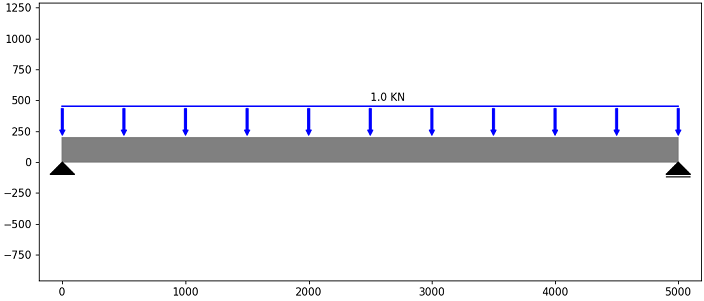

In [ ]:
# 3 span distributed load example

x, E, I, F = sp.symbols('x E I F')
l = sp.symbols('l', positive=True)
b3s = Beam(l, E, I)
R1,R2,R3,R4 = sp.symbols('R1 R2 R3 R4')
b3s.apply_load(R1, 0, -1)
b3s.apply_load(R2, l/3, -1)
b3s.apply_load(R3, 2*l/3, -1)
b3s.apply_load(R4, l, -1)
b3s.apply_load(-F, 0, 0)
b3s.bc_deflection = [(0, 0),(l/3, 0),(2*l/3, 0),(l, 0)]
b3s.solve_for_reaction_loads(R1, R2, R3,R4)

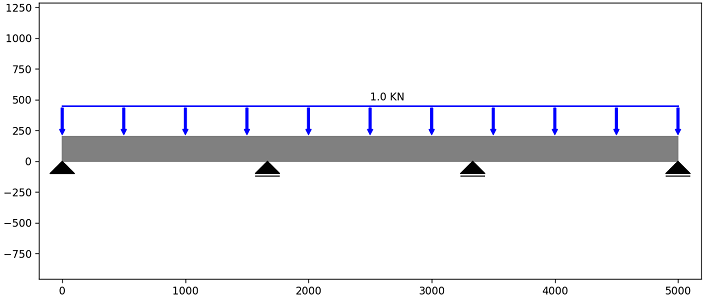

In [ ]:
# fixed support example

E, I, F = sp.symbols('E I F')
# l = sp.symbols('l', positive=True)
bf = Beam(l, E, I)
R1,R2 = sp.symbols('R1  R2')
M1, M2 = sp.symbols('M1, M2')
bf.apply_load(R1, 0, -1)
bf.apply_load(M1, 0, -2)
bf.apply_load(R2, l, -1)
bf.apply_load(M2, l, -2)
bf.apply_load(-F, l/2, -1)
bf.bc_deflection = [(0, 0),(l, 0)]
bf.bc_slope = [(0, 0),(l, 0)]
bf.solve_for_reaction_loads(R1, R2, M1, M2)

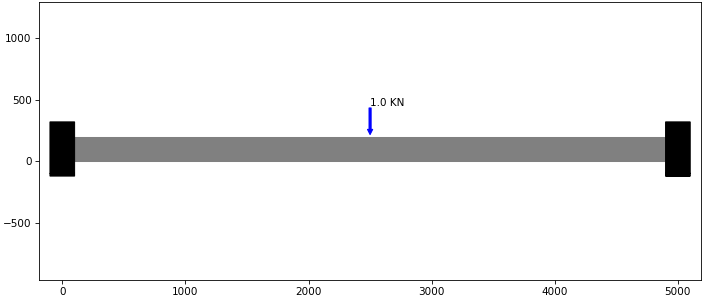

In [ ]:
conf_name = b3p # beam configuration name

M_ = conf_name.bending_moment().rewrite(sp.Piecewise)
M_


In [ ]:
Q_ = conf_name.shear_force().rewrite(sp.Piecewise)
Q_

In [ ]:
get_M = sp.lambdify((x,F,l), M_)
get_Q = sp.lambdify((x,F,l), Q_)

In [ ]:
mc = MomentCurvature()


#Todo:
# mc.A_j = 2323  
# Update the variables in the moment curvature package

In [ ]:
class CrossSectionDesign(InteractiveModel):

    name = 'CrossSectionDesign'
   
    # Reinforcement
    E_carbon = tr.Int(200000)
    width = tr.Float(8)
    thickness = tr.Float(1)
    spacing = tr.Float(1)
    n_layers = tr.Int(1)
    A_roving = tr.Float(1)
    f_h = tr.Int(5)

    #Concerte cross section
#     L = tr.Int(5000, param=True, latex='L \mathrm{mm}', minmax=(10,10000))
    H = tr.Int(10)
    B = tr.Int(10)
    E_con = tr.Int(14000)
    F = tr.Float(10)
    n_x = tr.Int(100)
    
    ipw_view = View(
        Item('E_carbon', param=True, latex='E_r \mathrm{[MPa]}', minmax=(200000,300000)),
        Item('width', param=True, latex='rov_w \mathrm{[mm]}', minmax=(8,450)),
        Item('thickness', param=True, latex='rov_t \mathrm{[mm]}', minmax=(1,100)),
        Item('spacing', param=True, latex='ro_s \mathrm{[mm]}', minmax=(1,100)),
        Item('n_layers', param=True, latex='n_l \mathrm{[-]}', minmax=(1,100)),
        Item('A_roving', param=True, latex='A_r \mathrm{[mm^2]}', minmax=(1,100)),
        Item('f_h', param=True, latex='f_h \mathrm{[mm]}', minmax=(5,500)),
        Item('H', param=True, latex='H \mathrm{[mm]}', minmax=(10,500)),
        Item('B', param=True, latex='B \mathrm{[mm]}', minmax=(10,500)),
        Item('E_con', param=True, latex='E \mathrm{[MPa]}', minmax=(14000,41000)),
        Item('F', param=True, latex='F \mathrm{[N]}', minmax=(10,1000)),
        Item('n_x', param=True, latex='n_x \mathrm{[-]}', minmax=(1,1000))
    )
    
    def get_comp_E(self):
        '''todo: check it with the bmcs example'''
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing # width or B??
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp
      
    def subplots(self, fig):
        return fig.subplots(1, 1)

    def update_plot(self, ax):     
        ax.axis([0, self.B, 0, self.H]);
        ax.axis('equal');
        ax.fill([0,self.B,self.B,0,0], [0,0,self.H,self.H,0],color='gray')
        ax.plot([0,self.B,self.B,0,0], [0,0,self.H,self.H,0],color='black')
        ax.plot([self.B/2 - self.width/2, self.B/2 + self.width/2], 
                [self.f_h,self.f_h],color='Blue',
                linewidth=self.n_layers*self.thickness)       
        ax.annotate('E_composite = {} GPa'.format(np.round(self.get_comp_E()/1000),0),
                xy=(self.B/10,self.f_h*1.1), color='white')

In [ ]:
beam_cs_layout = CrossSectionDesign()
bc_ii = InteractiveWindow(beam_cs_layout)
bc_ii.interact()

In [ ]:
class BeamDesign(InteractiveModel):
    
    name = 'BeamDesign'
   
    L = tr.Int(5000)
    H = tr.Int(200)
    ipw_view = View(
        Item('L', latex='L \mathrm{[mm]}', minmax=(1000,10000)),
        Item('H', latex='H \mathrm{[mm]}', minmax=(100,500))
    )
    
    def beamdefine(self):
        pass
    
    def subplots(self, fig):
        return fig.subplots(1, 1)

    def update_plot(self, ax):  
        
        ax.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        ax.annotate('L = {} mm'.format(np.round(self.L),0),
                xy=(self.L/2,self.H * 1.1), color='black')
        ax.axis('equal')

In [ ]:
beam_design = BeamDesign(cs_layout=beam_cs_layout)
InteractiveWindow([beam_design, beam_design.cs_layout]).interact()

In [ ]:
class BoundaryConditions(InteractiveModel):
    
    name = 'BoundaryConditions'
    
    L = tr.Int(5000, param=True, latex='L \mathrm{[mm]}', minmax=(1000,10000))
    H = tr.Int(200, param=True, latex='H \mathrm{[mm]}', minmax=(10,500))
    F = tr.Float(1000)
    n_sup = tr.Int(2)
    G_adj = tr.Float(0.02)
    F_pos = tr.Int(2500)

    ipw_view = View(
        Item('F', param=True, latex='F \mathrm{[N]}', minmax=(1000,10000)),
        Item('n_sup', param=True, latex='n_{sup} \mathrm{[-]}', minmax=(2,10)), #number of supports
        Item('G_adj', param=True, latex='G_{adj} \mathrm{[-]}', minmax=(1e-3,1e-1)), #Graphic adjustment factor
        Item('F_pos', param=True, latex='F_{pos} \mathrm{[mm]}', minmax=(0,10000)), # Force position
    )
  
    def suploc (self):
        
        # reading the position of the boundary conditions
        loc_d_ = []
        loc_s_ = []

        for i in range (0,len(conf_name.bc_deflection)):
            loc_d_.append(conf_name.bc_deflection[i][0])
        for i in range (0,len(conf_name.bc_slope)):
            loc_s_.append(conf_name.bc_slope[i][0])

        loc_d = dict(list(enumerate(loc_d_)))     # boundary conditions with confined deflection
        loc_d_l_ = sp.lambdify((l),loc_d)
        loc_d_l = (loc_d_l_(self.L))

        loc_s = dict(list(enumerate(loc_s_)))     # boundary conditions with confined slope
        loc_s_l_ = sp.lambdify((l),loc_s)
        loc_s_l = (loc_s_l_(self.L))    
    
        return loc_d_l, loc_s_l
    
    def subplots(self, fig):
        return fig.subplots(1, 1)

    def update_plot(self, ax):  
        
        # beam 
        ax.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
#         ax.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        
        # supports
        vertices = []
        codes = []
      
        for i in range (0, len((self.suploc()[0]))):

            codes += [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY] 
            vertices += [(self.suploc()[0][i] - self.L * (self.G_adj), -self.L * self.G_adj),
                         (self.suploc()[0][i] , 0),
                         (self.suploc()[0][i] + self.L * (self.G_adj), -self.L * self.G_adj), 
                         (self.suploc()[0][i] - self.L * (self.G_adj), -self.L * self.G_adj)]
            
            if self.suploc()[0][i] != 0:
                codes += [Path.MOVETO] + [Path.LINETO] + [Path.CLOSEPOLY] 
                vertices += [(self.suploc()[0][i] + (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                             (self.suploc()[0][i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                             (self.suploc()[0][i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2)]

        for i in range (0, len((self.suploc()[1]))):
            codes += [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY] 
            vertices += [(self.suploc()[1][i] - self.L * (self.G_adj), -self.L * self.G_adj*1.2),
                         (self.suploc()[1][i] - self.L * (self.G_adj) , self.H + self.L * self.G_adj*1.2),
                         (self.suploc()[1][i] + self.L * (self.G_adj), self.H + self.L * self.G_adj*1.2),
                         (self.suploc()[1][i] + self.L * (self.G_adj), -self.L * self.G_adj*1.2), 
                         (self.suploc()[1][i] - self.L * (self.G_adj), -self.L * self.G_adj*1.2)]
       

        vertices = np.array(vertices, float)
        path = Path(vertices, codes)
        pathpatch = PathPatch(path, facecolor='black', edgecolor='black')
        ax.add_patch(pathpatch)
        
        # loads
        load = conf_name.applied_loads
        value = [0]
        pos = [0]
        type = [0]
 
        #reading the value and the positoin of external loads
        for i in range (0, len(load)):
            if load[i][0] == -F or load[i][0] == F:
                value[0] = (load[i][0])
                pos[0] = (load[i][1])             
                load_dic = dict(zip(value,pos))
                load_ = sp.lambdify((F, l),load_dic)
                Load_x = load_(self.F,self.L)
                
                # load arrow parameters
                x_tail = (list(Load_x.values())[0])
                x_head = (list(Load_x.values())[0])
                
                # moment
                if load[i][2] == -2:
                    
                    if load[i][0] == -F:
                        
                        ax.plot([(list(Load_x.values())[0])],[(self.H/2)],
                            marker=r'$\circlearrowleft$',ms=self.H/5)
                        
                    else:
                        
                        ax.plot([(list(Load_x.values())[0])],[(self.H/2)],
                            marker=r'$\circlearrowright$',ms=self.H/5)
                    
                    ax.annotate('{} KN.mm'.format(np.round(self.F/1000),0),
                                xy=(list(Load_x.values())[0],self.H * 1.4), color='blue')
                    
                # point load   
                elif load[i][2] == -1:                  
                      
                    if load[i][0] == -F:
                        
                        y_tail = self.L/20 + self.H
                        y_head = 0 + self.H  
                        dy = y_head + x_head/10
                        
                        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                 color = 'blue',mutation_scale=self.L/500)
                        ax.annotate('{} KN'.format(np.round(self.F/1000),0),
                                xy=(x_tail,y_tail), color='black')
                        ax.add_patch(arrow)
                    
                    else:

                        y_tail = 0 + self.H
                        y_head = self.L/20 + self.H                             
                        dy = y_head + x_head/10
                        
                        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                 color = 'blue',mutation_scale=self.L/500)
                        ax.annotate('{} KN'.format(np.round(self.F/1000),0),
                                xy=(x_head,y_head), color='black')
                        ax.add_patch(arrow)
                    
                else:
                    
                    if load[i][0] == -F:
                        y_tail = self.L/20 + self.H
                        y_head = 0 + self.H   
                        dy = y_head + x_head/10
                        
                        # distributed load
                        l_step = 0
                        while l_step <= self.L:
                            x_tail = (list(Load_x.values())[0]) + l_step
                            y_tail = self.L/20 + self.H
                            x_head = (list(Load_x.values())[0]) + l_step
                            y_head = 0 + self.H
                            dy = y_head + x_head/10
                            l_step += self.L/10
                            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                     color = 'blue',mutation_scale=self.L/500)
                            ax.add_patch(arrow)

                        ax.annotate('{} KN'.format(np.round(self.F/1000),0),
                                    xy=(self.L/2,y_tail * 1.1), color='black')
                        ax.plot([0,self.L], [y_tail,y_tail],color='blue')
                    
                    else:
                        y_tail = 0 + self.H
                        y_head = self.L/20 + self.H   
                        dy = y_head + x_head/10
                        
                        # distributed load
                        l_step = 0
                        while l_step <= self.L:
                            x_tail = (list(Load_x.values())[0]) + l_step
                            y_tail = 0 + self.H
                            x_head = (list(Load_x.values())[0]) + l_step
                            y_head = self.L/20 + self.H
                            dy = y_head + x_head/10
                            l_step += self.L/10
                            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                     color = 'blue',mutation_scale=self.L/500)
                            ax.add_patch(arrow)

                        ax.annotate('{} KN'.format(np.round(self.F/1000),0),
                                    xy=(self.L/2,y_head * 1.1), color='black')
                        ax.plot([0,self.L], [y_head,y_head],color='blue')
               
        ax.axis('equal')
        ax.autoscale(tight=True)

In [ ]:
# conf_name = b3s

# conf_name.remove_load(-F, 0, 0)
# conf_name.apply_load(-F, l/2, -1)

beam_bc = BoundaryConditions(beam_design=beam_design)
InteractiveWindow([beam_bc,beam_bc.beam_design,beam_bc.beam_design.cs_layout]).interact()

In [ ]:
class BeamBending(InteractiveModel):

    name = 'Analysis'

#     boundarycondition = tr.Instance(BoundaryConditions)
#     def _boundarycondition_default(self):
#         return BoundaryConditions()
# commitmaker

    bc = tr.Instance(BoundaryConditions,())
    supports_loc = tr.Property(depends_on = 'bc')
    @tr.cached_property
    def _get_supports_loc(self):
        return  self.bc.suploc()
    
    mc = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_mc(self):
        mc_ = MomentCurvature()
        return mc_
    
    # Reinforcement
    E_carbon = tr.Int(200000)
    width = tr.Float(10)
    thickness = tr.Float(1)
    spacing = tr.Float(1)
    n_layers = tr.Int(1)
    A_roving = tr.Float(1)
    
    #Concerte cross section
    L = tr.Int(5000, param=True, latex='L \mathrm{mm}', minmax=(10,10000))
    H = tr.Int(200, param=True, latex='H \mathrm{mm}', minmax=(10,500))
#     B = tr.Int(10, param=True, latex='B \mathrm{mm}', minmax=(10,500))
    E_con = tr.Int(14000)
    F = tr.Float(5000)
    n_x = tr.Int(100)
    G_adj = tr.Float(0.015)

    ipw_view = View(
        Item('E_con', param=True, latex='E \mathrm{MPa}', minmax=(14000,41000)) ,
        Item('F', param=True, latex='F \mathrm{N}', minmax=(10,100000)),
        Item('E_carbon', param=True, latex='E_r \mathrm{MPa}', minmax=(200000,300000)),
        Item('width', param=True, latex='rov_w \mathrm{mm}', minmax=(10,450)),
        Item('thickness', param=True, latex='rov_t \mathrm{mm}', minmax=(1,100)),
        Item('spacing', param=True, latex='ro_s \mathrm{mm}', minmax=(1,100)),
        Item('n_layers', param=True, latex='n_l \mathrm{-}', minmax=(1,100)),
        Item('A_roving', param=True, latex='A_r \mathrm{mm^2}', minmax=(1,100)),
        Item('G_adj', param=True, latex='G_{adj} \mathrm{-}', minmax=(1e-3,1e-1)),
        Item('n_x',param=True, latex='n_x \mathrm{-}', minmax=(1,1000))
    )

    x = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_x(self):
        return np.linspace(0,self.L,self.n_x)
    
    E_comp = tr.Property(depends_on = '+param')
    @tr.cached_property
    
    def _get_E_comp(self):
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing 
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp   

    def get_M_x(self):
        M_x = get_M(self.x, self.F, self.L)
        return M_x
    
    def get_Q_x(self):
        Q_x = get_Q(self.x, self.F, self.L)
        return Q_x
    
    def get_kappa_x(self):
        M = self.get_M_x()
#         I = (self.B*self.H**3)/12
        return mc.get_kappa(M)
#         return M / I / self.E_comp
    
    #b3p, b4p & bdi (single span configs)
    def get_phi_x(self):
        kappa_x = self.get_kappa_x()
        phi_x = cumtrapz(kappa_x, self.x, initial=0)
        phi_L2 = np.interp(self.L/2, self.x, phi_x)
        phi_x -= phi_L2
        return phi_x
    
      #b3s
#     def get_phi_x(self):
#         kappa_x = self.get_kappa_x()
#         phi_x = cumtrapz(kappa_x, self.x, initial=0)
#         peaks, _ = find_peaks(M_x, height=0)
#         M_x_p = M_x[peaks]
#         phi_L2 = np.interp(self.M_x_p, self.x, phi_x)
#         phi_x -= phi_L2
#         return phi_x
    
    def get_w_x(self):
        phi_x = self.get_phi_x()
        w_x = cumtrapz(phi_x, self.x, initial=0)
        w_x += w_x[0]
        return w_x
    
    def subplots(self, fig):
        return fig.subplots(3, 1)

    def update_plot(self, axes):
        ax1, ax2, ax3 = axes
        
        # beam 
        ax1.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
#         ax.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        
        # supports
        vertices = []
        codes = []
      
        for i in range (0, len(self.supports_loc[0])):

            codes += [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY] 
            vertices += [(self.supports_loc[0][i] - self.L * (self.G_adj), -self.L * self.G_adj),
                         (self.supports_loc[0][i] , 0),
                         (self.supports_loc[0][i] + self.L * (self.G_adj), -self.L * self.G_adj), 
                         (self.supports_loc[0][i] - self.L * (self.G_adj), -self.L * self.G_adj)]
            
            if self.supports_loc[0][i] != 0:
                codes += [Path.MOVETO] + [Path.LINETO] + [Path.CLOSEPOLY] 
                vertices += [(self.supports_loc[0][i] + (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                             (self.supports_loc[0][i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                             (self.supports_loc[0][i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2)]

        for i in range (0, len((self.supports_loc[1]))):
            codes += [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY] 
            vertices += [(self.supports_loc[1][i] - self.L * (self.G_adj), -self.L * self.G_adj*1.2),
                         (self.supports_loc[1][i] - self.L * (self.G_adj) , self.H + self.L * self.G_adj*1.2),
                         (self.supports_loc[1][i] + self.L * (self.G_adj), self.H + self.L * self.G_adj*1.2),
                         (self.supports_loc[1][i] + self.L * (self.G_adj), -self.L * self.G_adj*1.2), 
                         (self.supports_loc[1][i] - self.L * (self.G_adj), -self.L * self.G_adj*1.2)]
       

        vertices = np.array(vertices, float)
        path = Path(vertices, codes)
        pathpatch = PathPatch(path, facecolor='black', edgecolor='black')
        ax1.add_patch(pathpatch)
        
        # loads
        load = conf_name.applied_loads
        value = [0]
        pos = [0]
        type = [0]
 
        #reading the value and the positoin of external loads
        for i in range (0, len(load)):
            if load[i][0] == -F or load[i][0] == F:
                value[0] = (load[i][0])
                pos[0] = (load[i][1])             
                load_dic = dict(zip(value,pos))
                load_ = sp.lambdify((F, l),load_dic)
                Load_x = load_(self.F,self.L)
                
                # load arrow parameters
                x_tail = (list(Load_x.values())[0])
                x_head = (list(Load_x.values())[0])
                
                # moment
                if load[i][2] == -2:
                    
                    if load[i][0] == -F:
                        
                        ax1.plot([(list(Load_x.values())[0])],[(self.H/2)],
                            marker=r'$\circlearrowleft$',ms=self.H/5)
                        
                    else:
                        
                        ax1.plot([(list(Load_x.values())[0])],[(self.H/2)],
                            marker=r'$\circlearrowright$',ms=self.H/5)
                    
                    ax1.annotate('{} KN.mm'.format(np.round(self.F/1000),0),
                                xy=(list(Load_x.values())[0],self.H * 1.4), color='blue')
                    
                # point load   
                elif load[i][2] == -1:                  
                      
                    if load[i][0] == -F:
                        
                        y_tail = self.L/20 + self.H
                        y_head = 0 + self.H  
                        dy = y_head + x_head/10
                        
                        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                 color = 'blue',mutation_scale=self.L/500)
                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                xy=(x_tail,y_tail), color='black')
                        ax1.add_patch(arrow)
                    
                    else:

                        y_tail = 0 + self.H
                        y_head = self.L/20 + self.H                             
                        dy = y_head + x_head/10
                        
                        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                 color = 'blue',mutation_scale=self.L/500)
                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                xy=(x_head,y_head), color='black')
                        ax1.add_patch(arrow)
                    
                else:
                    
                    if load[i][0] == -F:
                        y_tail = self.L/20 + self.H
                        y_head = 0 + self.H   
                        dy = y_head + x_head/10
                        
                        # distributed load
                        l_step = 0
                        while l_step <= self.L:
                            x_tail = (list(Load_x.values())[0]) + l_step
                            y_tail = self.L/20 + self.H
                            x_head = (list(Load_x.values())[0]) + l_step
                            y_head = 0 + self.H
                            dy = y_head + x_head/10
                            l_step += self.L/10
                            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                     color = 'blue',mutation_scale=self.L/500)
                            ax1.add_patch(arrow)

                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                    xy=(self.L/2,y_tail * 1.1), color='black')
                        ax1.plot([0,self.L], [y_tail,y_tail],color='blue')
                    
                    else:
                        y_tail = 0 + self.H
                        y_head = self.L/20 + self.H   
                        dy = y_head + x_head/10
                        
                        # distributed load
                        l_step = 0
                        while l_step <= self.L:
                            x_tail = (list(Load_x.values())[0]) + l_step
                            y_tail = 0 + self.H
                            x_head = (list(Load_x.values())[0]) + l_step
                            y_head = self.L/20 + self.H
                            dy = y_head + x_head/10
                            l_step += self.L/10
                            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                     color = 'blue',mutation_scale=self.L/500)
                            ax1.add_patch(arrow)

                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                    xy=(self.L/2,y_head * 1.1), color='black')
                        ax1.plot([0,self.L], [y_head,y_head],color='blue')

        
        x = self.x
        
        M_x = self.get_M_x()
        ax2.plot(x, -M_x, color='red', label='moment [N.mm]')
        leg = ax2.legend();
        
        Q_x = self.get_Q_x()
        ax3.plot(x, Q_x, color='green', label='shear [N]')
        leg = ax3.legend();
        
#         kappa_x = self.get_kappa_x()
#         ax3.plot(x, kappa_x, color='black', label='$kappa$ [-]')
#         leg = ax3.legend();
        
#         phi_x = self.get_phi_x()
#         ax4.plot(x, phi_x, color='green', label='phi [-]')
#         leg = ax4.legend();
        
#         w_x = self.get_w_x()
#         ax5.plot(x, w_x, color='blue', label='$w$ [mm]')
#         leg = ax5.legend();

In [ ]:
# conf_name = bdi

beam_bcs = BeamBending(beam_bc=beam_bc)
InteractiveWindow([beam_bcs.beam_bc,beam_bcs.beam_bc.beam_design,beam_bcs.beam_bc.beam_design.cs_layout,beam_bcs]).interact()

In [ ]:
class MomentCurvatureProfile(InteractiveModel):

    name = 'M_K Profile'
    mc = MomentCurvature(
            kappa_range = (-0.0002, 0.0002, 100),
            idx=100, n_m=100)

    # Reinforcement
    E_carbon = tr.Int(200000)
    width = tr.Float(8)
    thickness = tr.Float(1)
    spacing = tr.Float(1)
    n_layers = tr.Int(1)
    A_roving = tr.Float(1)
    f_h = tr.Int(5)

    #Concerte cross section
    H = tr.Int(10)
    B = tr.Int(10)
    E_con = tr.Int(14000)
    F = tr.Float(10)
    n_x = tr.Int(100)
    
    ipw_view = View(
        Item('E_carbon', param=True, latex='E_r \mathrm{[MPa]}', minmax=(200000,300000)),
        Item('width', param=True, latex='rov_w \mathrm{[mm]}', minmax=(8,450)),
        Item('thickness', param=True, latex='rov_t \mathrm{[mm]}', minmax=(1,100)),
        Item('spacing', param=True, latex='ro_s \mathrm{[mm]}', minmax=(1,100)),
        Item('n_layers', param=True, latex='n_l \mathrm{[-]}', minmax=(1,100)),
        Item('A_roving', param=True, latex='A_r \mathrm{[mm^2]}', minmax=(1,100)),
        Item('f_h', param=True, latex='f_h \mathrm{[mm]}', minmax=(5,500)),
        Item('H', param=True, latex='H \mathrm{[mm]}', minmax=(10,500)),
        Item('B', param=True, latex='B \mathrm{[mm]}', minmax=(10,500)),
        Item('E_con', param=True, latex='E \mathrm{[MPa]}', minmax=(14000,41000)),

    )
    
    
    def subplots(self, fig):
        return fig.subplots(1, 2)

    def update_plot(self, axes):
        ax1, ax2 = axes
        
        ax1.plot(mc.kappa_t, mc.M_t)
        ax1.set_xlabel('Kappa')
        ax1.set_ylabel('Moment')
        
        ax2.plot(*mc.M_kappa_data)

In [ ]:
beam_mk = MomentCurvatureProfile(beam_bcs=beam_bcs)
InteractiveWindow([beam_mk.beam_bcs, beam_mk.beam_bcs.beam_bc, beam_mk.beam_bcs.beam_bc.beam_design, beam_mk.beam_bcs.beam_bc.beam_design.cs_layout, beam_mk]).interact()

In [ ]:
class Deflection(InteractiveModel):

    name = 'Deflection'


    bc = tr.Instance(BoundaryConditions,())
    supports_loc = tr.Property(depends_on = 'bc')
    @tr.cached_property
    def _get_supports_loc(self):
        return  self.bc.suploc()
    
    mc = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_mc(self):
        mc_ = MomentCurvature()
        return mc_
    
    # Reinforcement
    E_carbon = tr.Int(200000)
    width = tr.Float(10)
    thickness = tr.Float(1)
    spacing = tr.Float(1)
    n_layers = tr.Int(1)
    A_roving = tr.Float(1)
    
    #Concerte cross section
    L = tr.Int(5000, param=True, latex='L \mathrm{mm}', minmax=(10,10000))
    H = tr.Int(200, param=True, latex='H \mathrm{mm}', minmax=(10,500))
#     B = tr.Int(10, param=True, latex='B \mathrm{mm}', minmax=(10,500))
    E_con = tr.Int(14000)
    F = tr.Float(5000)
    n_x = tr.Int(100)
    G_adj = tr.Float(0.015)

    ipw_view = View(
        Item('E_con', param=True, latex='E \mathrm{MPa}', minmax=(14000,41000)) ,
        Item('F', param=True, latex='F \mathrm{N}', minmax=(10,100000)),
        Item('E_carbon', param=True, latex='E_r \mathrm{MPa}', minmax=(200000,300000)),
        Item('width', param=True, latex='rov_w \mathrm{mm}', minmax=(10,450)),
        Item('thickness', param=True, latex='rov_t \mathrm{mm}', minmax=(1,100)),
        Item('spacing', param=True, latex='ro_s \mathrm{mm}', minmax=(1,100)),
        Item('n_layers', param=True, latex='n_l \mathrm{-}', minmax=(1,100)),
        Item('A_roving', param=True, latex='A_r \mathrm{mm^2}', minmax=(1,100)),
        Item('G_adj', param=True, latex='G_{adj} \mathrm{-}', minmax=(1e-3,1e-1)),
        Item('n_x',param=True, latex='n_x \mathrm{-}', minmax=(1,1000))
    )

    x = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_x(self):
        return np.linspace(0,self.L,self.n_x)
    
    E_comp = tr.Property(depends_on = '+param')
    @tr.cached_property
    
    def _get_E_comp(self):
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing 
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp   

    def get_M_x(self):
        M_x = get_M(self.x, self.F, self.L)
        return M_x
    
    def get_Q_x(self):
        Q_x = get_Q(self.x, self.F, self.L)
        return Q_x
    
    def get_kappa_x(self):
        M = self.get_M_x()
#         I = (self.B*self.H**3)/12
        return mc.get_kappa(M)
#         return M / I / self.E_comp
    
    #b3p, b4p & bdi (single span configs)
    def get_phi_x(self):
        kappa_x = self.get_kappa_x()
        phi_x = cumtrapz(kappa_x, self.x, initial=0)
        phi_L2 = np.interp(self.L/2, self.x, phi_x)
        phi_x -= phi_L2
        return phi_x
    
      #b3s
#     def get_phi_x(self):
#         kappa_x = self.get_kappa_x()
#         phi_x = cumtrapz(kappa_x, self.x, initial=0)
#         peaks, _ = find_peaks(M_x, height=0)
#         M_x_p = M_x[peaks]
#         phi_L2 = np.interp(self.M_x_p, self.x, phi_x)
#         phi_x -= phi_L2
#         return phi_x
    
    def get_w_x(self):
        phi_x = self.get_phi_x()
        w_x = cumtrapz(phi_x, self.x, initial=0)
        w_x += w_x[0]
        return w_x
    
    def subplots(self, fig):
        return fig.subplots(3, 1)

    def update_plot(self, axes):
        ax1, ax2, ax3 = axes
        
        # beam 
        ax1.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
#         ax.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        
        # supports
        vertices = []
        codes = []
      
        for i in range (0, len(self.supports_loc[0])):

            codes += [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY] 
            vertices += [(self.supports_loc[0][i] - self.L * (self.G_adj), -self.L * self.G_adj),
                         (self.supports_loc[0][i] , 0),
                         (self.supports_loc[0][i] + self.L * (self.G_adj), -self.L * self.G_adj), 
                         (self.supports_loc[0][i] - self.L * (self.G_adj), -self.L * self.G_adj)]
            
            if self.supports_loc[0][i] != 0:
                codes += [Path.MOVETO] + [Path.LINETO] + [Path.CLOSEPOLY] 
                vertices += [(self.supports_loc[0][i] + (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                             (self.supports_loc[0][i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                             (self.supports_loc[0][i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2)]

        for i in range (0, len((self.supports_loc[1]))):
            codes += [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY] 
            vertices += [(self.supports_loc[1][i] - self.L * (self.G_adj), -self.L * self.G_adj*1.2),
                         (self.supports_loc[1][i] - self.L * (self.G_adj) , self.H + self.L * self.G_adj*1.2),
                         (self.supports_loc[1][i] + self.L * (self.G_adj), self.H + self.L * self.G_adj*1.2),
                         (self.supports_loc[1][i] + self.L * (self.G_adj), -self.L * self.G_adj*1.2), 
                         (self.supports_loc[1][i] - self.L * (self.G_adj), -self.L * self.G_adj*1.2)]
       

        vertices = np.array(vertices, float)
        path = Path(vertices, codes)
        pathpatch = PathPatch(path, facecolor='black', edgecolor='black')
        ax1.add_patch(pathpatch)
        
        # loads
        load = conf_name.applied_loads
        value = [0]
        pos = [0]
        type = [0]
 
        #reading the value and the positoin of external loads
        for i in range (0, len(load)):
            if load[i][0] == -F or load[i][0] == F:
                value[0] = (load[i][0])
                pos[0] = (load[i][1])             
                load_dic = dict(zip(value,pos))
                load_ = sp.lambdify((F, l),load_dic)
                Load_x = load_(self.F,self.L)
                
                # load arrow parameters
                x_tail = (list(Load_x.values())[0])
                x_head = (list(Load_x.values())[0])
                
                # moment
                if load[i][2] == -2:
                    
                    if load[i][0] == -F:
                        
                        ax1.plot([(list(Load_x.values())[0])],[(self.H/2)],
                            marker=r'$\circlearrowleft$',ms=self.H/5)
                        
                    else:
                        
                        ax1.plot([(list(Load_x.values())[0])],[(self.H/2)],
                            marker=r'$\circlearrowright$',ms=self.H/5)
                    
                    ax1.annotate('{} KN.mm'.format(np.round(self.F/1000),0),
                                xy=(list(Load_x.values())[0],self.H * 1.4), color='blue')
                    
                # point load   
                elif load[i][2] == -1:                  
                      
                    if load[i][0] == -F:
                        
                        y_tail = self.L/20 + self.H
                        y_head = 0 + self.H  
                        dy = y_head + x_head/10
                        
                        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                 color = 'blue',mutation_scale=self.L/500)
                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                xy=(x_tail,y_tail), color='black')
                        ax1.add_patch(arrow)
                    
                    else:

                        y_tail = 0 + self.H
                        y_head = self.L/20 + self.H                             
                        dy = y_head + x_head/10
                        
                        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                 color = 'blue',mutation_scale=self.L/500)
                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                xy=(x_head,y_head), color='black')
                        ax1.add_patch(arrow)
                    
                else:
                    
                    if load[i][0] == -F:
                        y_tail = self.L/20 + self.H
                        y_head = 0 + self.H   
                        dy = y_head + x_head/10
                        
                        # distributed load
                        l_step = 0
                        while l_step <= self.L:
                            x_tail = (list(Load_x.values())[0]) + l_step
                            y_tail = self.L/20 + self.H
                            x_head = (list(Load_x.values())[0]) + l_step
                            y_head = 0 + self.H
                            dy = y_head + x_head/10
                            l_step += self.L/10
                            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                     color = 'blue',mutation_scale=self.L/500)
                            ax1.add_patch(arrow)

                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                    xy=(self.L/2,y_tail * 1.1), color='black')
                        ax1.plot([0,self.L], [y_tail,y_tail],color='blue')
                    
                    else:
                        y_tail = 0 + self.H
                        y_head = self.L/20 + self.H   
                        dy = y_head + x_head/10
                        
                        # distributed load
                        l_step = 0
                        while l_step <= self.L:
                            x_tail = (list(Load_x.values())[0]) + l_step
                            y_tail = 0 + self.H
                            x_head = (list(Load_x.values())[0]) + l_step
                            y_head = self.L/20 + self.H
                            dy = y_head + x_head/10
                            l_step += self.L/10
                            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                                     color = 'blue',mutation_scale=self.L/500)
                            ax1.add_patch(arrow)

                        ax1.annotate('{} KN'.format(np.round(self.F/1000),0),
                                    xy=(self.L/2,y_head * 1.1), color='black')
                        ax1.plot([0,self.L], [y_head,y_head],color='blue')

        
        x = self.x
        
#         M_x = self.get_M_x()
#         ax2.plot(x, -M_x, color='red', label='moment [N.mm]')
#         leg = ax2.legend();
        
#         Q_x = self.get_Q_x()
#         ax3.plot(x, Q_x, color='green', label='shear [N]')
#         leg = ax3.legend();
        
        kappa_x = self.get_kappa_x()
        ax2.plot(x, kappa_x, color='black', label='$kappa$ [-]')
        leg = ax2.legend();
        
#         phi_x = self.get_phi_x()
#         ax4.plot(x, phi_x, color='green', label='phi [-]')
#         leg = ax4.legend();
        
        w_x = self.get_w_x()
        ax3.plot(x, w_x, color='blue', label='$w$ [mm]')
        leg = ax3.legend();

In [ ]:
beam_de = Deflection(beam_mk=beam_mk)
InteractiveWindow([beam_de.beam_mk.beam_bcs, beam_de.beam_mk.beam_bcs.beam_bc, beam_de.beam_mk.beam_bcs.beam_bc.beam_design, beam_de.beam_mk.beam_bcs.beam_bc.beam_design.cs_layout, beam_de.beam_mk, beam_de]).interact()